In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms, utils
from torch.utils import data

import matplotlib.pyplot as plt
import numpy as np

In [2]:
#!pip install ipdb

In [3]:
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")

In [4]:
EPOCHS     = 10
BATCH_SIZE = 64

In [5]:
mnist_transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,)) # mean and std
                   ])

In [6]:
trainset = datasets.MNIST(
    root      = '../data/', 
    train     = True,
    download  = True,
    transform = mnist_transform
)
testset = datasets.MNIST(
    root      = '../data/', 
    train     = False,
    download  = True,
    transform = mnist_transform
)

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [7]:
train_loader = data.DataLoader(
    dataset     = trainset,
    batch_size  = BATCH_SIZE, shuffle=True
)
test_loader = data.DataLoader(
    dataset     = testset,
    batch_size  = BATCH_SIZE, shuffle=True
)

In [8]:
CLASSES = {
    0: 'zero',
    1: 'one',
    2: 'two',
    3: 'three',
    4: 'four',
    5: 'five',
    6: 'six',
    7: 'seven',
    8: 'eight',
    9: 'nine'
}

In [9]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

(28, 28)


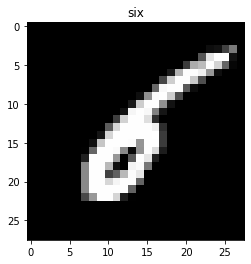

In [10]:
idx = 1

item_img = images[idx]
item_npimg = item_img.squeeze().numpy()
plt.title(CLASSES[labels[idx].item()])
print(item_npimg.shape)
plt.imshow(item_npimg, cmap='gray')
plt.show()

In [11]:
# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.fc1 = nn.Linear(784, 256)
#         self.fc2 = nn.Linear(256, 128)
#         self.fc3 = nn.Linear(128, 10)

#     def forward(self, x):
#         x = x.view(-1, 784)
# #         x = F.relu(self.fc1(x))
# #         x = F.relu(self.fc2(x))        
#         x = torch.sigmoid(self.fc1(x))
#         x = torch.sigmoid(self.fc2(x))
#         x = self.fc3(x)
#         return x

In [12]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        # import ipdb
        # ipdb.set_trace()
        x = self.conv1(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x#F.log_softmax(x, dim=1)

In [13]:
model     = Net().to(DEVICE)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

In [14]:
def train(model, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % 200 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [15]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)

            # 배치 오차를 합산
            test_loss += F.cross_entropy(output, target,
                                         reduction='sum').item()

            # 가장 높은 값을 가진 인덱스가 바로 예측값
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [16]:
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, epoch)
    test_loss, test_accuracy = evaluate(model, test_loader)
    
    print('[{}] Test Loss: {:.4f}, Accuracy: {:.2f}%'.format(
          epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.304410
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.480093
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.224313
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.180894
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.131478
[1] Test Loss: 0.1187, Accuracy: 96.61%
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.093142
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.088932
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.089263
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.023216
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.115041
[2] Test Loss: 0.0792, Accuracy: 97.77%
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.130573
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.106396
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.082532
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.019241
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.179485
[3] Test Loss: 0.0622, Accuracy: 97.97%
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.007374
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.025358
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.079630


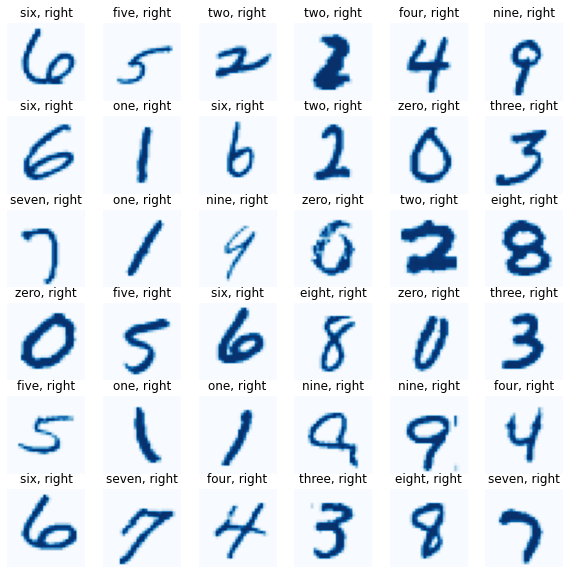

In [17]:
columns = 6
rows = 6
fig = plt.figure(figsize=(10,10))
 
model.eval()
for i in range(1, columns*rows+1):
    data_idx = np.random.randint(len(testset))
    input_img = testset[data_idx][0].unsqueeze(dim=0).to(DEVICE) 
 
    output = model(input_img)
    _, argmax = torch.max(output, 1)
    pred = CLASSES[argmax.item()]
    label = CLASSES[testset[data_idx][1]]
    
    fig.add_subplot(rows, columns, i)
    if pred == label:
        plt.title(pred + ', right')
        cmap = 'Blues'
    else:
        plt.title('N ' + pred + ' B ' +  label)
        cmap = 'Reds'
    plot_img = testset[data_idx][0][0,:,:]
    plt.imshow(plot_img, cmap=cmap)
    plt.axis('off')
    
plt.show() 

## CNN의 channel, kernel size, stride, padding 을 변경해보자!

## Convolution Dropout을 추가하여 성능을 비교해보자!

In [18]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d(p=0.2) ## convolution Dropout
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        # import ipdb
        # ipdb.set_trace()
        x = self.conv1(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)